### 訓練報告

- Version
  - v4
    - a=1, b=0，完全依賴舒適度
    - 使用2~11月資料，去除冬季資料訓練
  - v5
    - a=0.7, b=0.3，
    - 使用2~11月資料，去除冬季資料訓練
    ```
    === 能耗統計 ===
         DQN 平均耗電量: 49.801 kWh, 標準差: 41.001
    Heuristic 平均耗電量: 20.848 kWh, 標準差: 21.668
    配對 t 檢定（能耗）: t = 6.271, p = 0.000
    === THI 占比 (22~24) 統計 ===
         DQN 平均占比: 0.274, 標準差: 0.228
    Heuristic 平均占比: 0.160, 標準差: 0.115
    配對 t 檢定 (22~24): t = 3.687, p = 0.002
    === THI 占比 (19~27) 統計 ===
         DQN 平均占比: 0.802, 標準差: 0.252
    Heuristic 平均占比: 0.795, 標準差: 0.247
    配對 t 檢定 (19~27): t = 2.728, p = 0.013
    ```
  - v6
    - a=0.5, b=0.5，
    - 使用2~11月資料，去除冬季資料訓練
    ```
    === 能耗統計 ===
         DQN 平均耗電量: 105.314 kWh, 標準差: 17.929
    Heuristic 平均耗電量: 20.848 kWh, 標準差: 21.668
    配對 t 檢定（能耗）: t = 17.728, p = 0.000
    === THI 占比 (22~24) 統計 ===
         DQN 平均占比: 0.228, 標準差: 0.174
    Heuristic 平均占比: 0.160, 標準差: 0.115
    配對 t 檢定 (22~24): t = 1.273, p = 0.218
    === THI 占比 (19~27) 統計 ===
         DQN 平均占比: 0.650, 標準差: 0.330
    Heuristic 平均占比: 0.795, 標準差: 0.247
    配對 t 檢定 (19~27): t = -5.430, p = 0.000
      ```
  - v7
    - a=0.3, b=0.7
    - 使用2~11月資料，去除冬季資料訓練
    ```
    === 能耗統計 ===
         DQN 平均耗電量: 5.737 kWh, 標準差: 7.130
    Heuristic 平均耗電量: 20.848 kWh, 標準差: 21.668
    配對 t 檢定（能耗）: t = -4.460, p = 0.000
    === THI 占比 (22~24) 統計 ===
         DQN 平均占比: 0.155, 標準差: 0.111
    Heuristic 平均占比: 0.160, 標準差: 0.115
    配對 t 檢定 (22~24): t = -3.067, p = 0.006
    === THI 占比 (19~27) 統計 ===
         DQN 平均占比: 0.671, 標準差: 0.219
    Heuristic 平均占比: 0.795, 標準差: 0.247
    配對 t 檢定 (19~27): t = -2.945, p = 0.008
    ```

In [ ]:
! nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
!pip show gym

Name: gym
Version: 0.25.2
Summary: Gym: A universal API for reinforcement learning environments
Home-page: https://www.gymlibrary.ml/
Author: Gym Community
Author-email: jkterry@umd.edu
License: MIT
Location: /usr/local/lib/python3.11/dist-packages
Requires: cloudpickle, gym_notices, numpy
Required-by: dopamine_rl


In [ ]:
!pip install psychrolib

  Preparing metadata (setup.py) ... done
  Created wheel for psychrolib: filename=PsychroLib-2.5.0-py3-none-any.whl size=9766 sha256=b5a35fec08e6032ee3f2c1fec7e07d71d1f016d47f85276d6e93e3cb263a8798
  Stored in directory: /root/.cache/pip/wheels/db/56/d2/160fe5cd010497f465b750b273cc5596f7dbbd139622428d11
Successfully built psychrolib


In [ ]:
import psychrolib

psychrolib.SetUnitSystem(psychrolib.SI)

### 建立模擬環境

In [ ]:
import gym
from gym import spaces
import numpy as np
import pandas as pd
import math
import psychrolib

psychrolib.SetUnitSystem(psychrolib.SI)

class AirConditioningEnv(gym.Env):
    def __init__(self, csv_path, episode_length=168, render_mode=None):
        super(AirConditioningEnv, self).__init__()
        self.render_mode = render_mode
        self.episode_length = episode_length  # The number of steps per episode (e.g. 24 for one day)
        self.step_counter = 0

        # read CSV
        self.weather_data = pd.read_csv(csv_path)

        # make sure CSV included T_outside and AH
        if "氣溫(℃)" not in self.weather_data.columns or "AH(g/m³)" not in self.weather_data.columns:
            raise ValueError("CSV 檔案缺少必要的欄位 '氣溫(℃)' 或 'AH(g/m³)'！")


        # State space: ac temperature, outdoor temperature, power consumption, THI, indoor temperature
        self.observation_space = spaces.Box(
            # Minimum ac temperature 16°C, outdoor -1°C, power consumption 0 kWh, THI 0, indoor -1°C
            low=np.array([16, -1, 0, 0, -1], dtype=np.float32),
            # Maximum ac temperature 30°C, outdoor 40°C, power consumption 3 kWh, THI 35, indoor 40°C
            high=np.array([30, 40, 3, 35, 40], dtype=np.float32),
            dtype=np.float32
        )

        # Action space: [0: reduce ac temperature, 1: maintain, 2: increase ac temperature]
        self.action_space = spaces.Discrete(3)

        # Initialize environment variables
        self.T_ac = 25
        # Random starting point, To track the number of CSV data currently read
        self.current_index = np.random.randint(0, len(self.weather_data) - self.episode_length)
        self.T_outside = self.weather_data.iloc[self.current_index]["氣溫(℃)"]
        self.date = self.weather_data.iloc[self.current_index]["觀測時間(hour)"]
        self.T_in = self.T_outside  # Initial indoor temperature is the same as the outside temperature
        self.energy_consumption = 0

    # Calculate THI
    def calculate_THI(self, T, AH):
        RH = self.absolute_to_relative_humidity(T, AH) / 100
        # If RH is outside the range [0,1], it is truncated to a reasonable range.
        if RH < 0 or RH > 1:
            RH = np.clip(RH, 0, 1)
        Td = psychrolib.GetTDewPointFromRelHum(T, RH)
        THI = T - 0.55 * (1 - np.exp((17.269 * Td) / (Td + 237.3)) / np.exp((17.269 * T) / (T + 237.3))) * (T - 14)
        if np.isnan(THI):
            print("NaN detected in env THI!")
            print(f"T: {T}, AH: {AH}")
        return THI

    # Calculate power consumption
    def calculate_power_consumption(self, T_out, T_in, Cooling_capacity=2):
        """
        When the outdoor temperature is lower than the air conditioning temperature,
        the air conditioning is turned off,
        and the power consumption : 0
        """
        if T_in == 0:
          return 0
        if T_out > T_in:
          PowerConsumption = Cooling_capacity * (T_out - T_in) / T_in
        else:
          PowerConsumption = 0
        return PowerConsumption
    # Min-Max Normalization
    def normalize(self, value, min_val, max_val):
        return (value - min_val) / (max_val - min_val)

    # Calculate absolute to relative humidity
    def absolute_to_relative_humidity(self, T, AH):
        """
        From absolute humidity AH(g/m³) and temperature T(°C) to calculate relative humidity RH(%)
        "New Equations for Computing Vapor Pressure and Enhancement Factor(Arden L. Buck)"
        eq: a * exp(b*T / (T+c))
        1. a is the saturated vapor pressure of water at different temperatures
        2. b and c is the empirical coefficient
        3. b and c use temperature inerval 0 ~ 50
        4. 217 is Correction of molar mass of water(Mw=18.015 g/mol)
        5. T + 273.15 is ℃ to K
        """
        # Calculate the Saturated water vapor pressure(hPa)
        Es = 6.1121 * np.exp((17.368 * T) / (T + 238.88))
        # Calculating the Actual water vapor pressure(hPa)
        Ea = (AH * (T + 273.15)) / 217
        # Calculating relative humidity(%)
        RH = ((Ea / Es) * 100).round(3)
        return RH

    # Calculate Reward
    def calculate_reward(self, AH, T_out, T_in, a=1, b=0, k=10, THI_optimal=23, Power_min=0, Power_max=3):
        """
        1. 利用 self.calculate_THI(T_in, AH) 計算 THI
        2. 計算 PowerConsumption 及其正規化值 Power_norm
        3. 利用 smooth_reward 函數計算 THI_reward，其中：
          - THI < 10 or THI > 30 時，reward = -1
          - THI 在 10～15 或 27～30 時，reward = -0.95
          - THI 在 15～19 時，reward = -0.9
          - THI 在 19～22 或 24～27 時，reward = -0.4
          - THI 在 22～24 時，reward = 0
          此函數利用多個 sigmoid 函數在臨界點處平滑過渡
        4. 最終 reward = a * THI_reward - b * Power_norm
        """
        THI = self.calculate_THI(T_in, AH)
        PowerConsumption = self.calculate_power_consumption(T_out, T_in)
        Power_norm = self.normalize(PowerConsumption, Power_min, Power_max)

        # Define a smooth THI reward function
        def smooth_reward(THI, k=10):
            def S(t):
                return 1 / (1 + np.exp(-k * (THI - t)))
            return (0.05 * S(10) + 0.05 * S(15) + 0.5 * S(19) + 0.4 * S(22) - 0.4 * S(24) - 0.55 * S(27) - 0.05 * S(30)) - 1

        THI_reward = smooth_reward(THI, k)

        reward = a * THI_reward - b * Power_norm
        return reward, THI, PowerConsumption

    def step(self, action):
        """ Update the environment based on the action and calculate the reward """

        # Get the CSV external temperature and absolute humidity at the corresponding time
        self.T_outside = self.weather_data.iloc[self.current_index]["氣溫(℃)"]
        AH = self.weather_data.iloc[self.current_index]["AH(g/m³)"]
        self.date = self.weather_data.iloc[self.current_index]["觀測時間(hour)"]
        self.current_index += 1  # Update the index and enter the next hour
        self.step_counter += 1

        # Movement affects ac temperature
        if action == 0:  # Lower the ac temperature
            self.T_ac = max(16, self.T_ac - 1)
        elif action == 2:  # Increase ac temperature
            self.T_ac = min(30, self.T_ac + 1)

        # Determine the indoor temperature
        if self.T_ac < self.T_outside:
            self.T_in = self.T_ac  # The ac is on, indoor temperature equals to the ac set temperature
        else:
            self.T_in = self.T_outside  # ac is off, indoor temperature equals outdoor temperature

        # Calculating reward
        reward, THI, PowerConsumption = self.calculate_reward(AH, self.T_outside, self.T_in, a=0.5, b=0.5)

        # Calculate power consumption
        self.energy_consumption += PowerConsumption

        # Environmental natural termination conditions
        done = self.step_counter >= self.episode_length or self.current_index >= len(self.weather_data)

        # New state
        state = np.array([self.T_ac, self.T_outside, PowerConsumption, THI, self.T_in], dtype=np.float32)

        info = {"THI": THI, "energy": self.energy_consumption, "date": self.date}

        return state, reward, done, info

    def reset(self, seed=None, options=None, return_info=False):
        if seed is not None:
          # Set numpy random seed
          np.random.seed(seed)
        self.T_ac = 25
        self.energy_consumption = 0
        PowerConsumption = 0
        self.step_counter = 0
        self.current_index = np.random.randint(0, len(self.weather_data) - self.episode_length)
        self.T_outside = self.weather_data.iloc[self.current_index]["氣溫(℃)"]
        AH = self.weather_data.iloc[self.current_index]["AH(g/m³)"]

        if self.T_ac < self.T_outside:
            self.T_in = self.T_ac
        else:
            self.T_in = self.T_outside

        THI = self.calculate_THI(self.T_in, AH)

        # Return initial status
        state = np.array([self.T_ac, self.T_outside, PowerConsumption, THI, self.T_in], dtype=np.float32)
        if return_info:
            return state, {}
        return state

    def render(self, mode="human"):
        """ Alternative methods of visualizing the environment """
        print(f"Outside Temp: {self.T_outside:.2f}°C, AC Temp: {self.T_ac}, Energy: {self.energy_consumption:.2f} Wh")


#### reward


##### 拋物線

In [ ]:
def calculate_reward(self, AH, T_out, T_in, a=0.9, b=0.1, THI_optimal=23, THI_min=0, THI_max=35, Power_min=0, Power_max=3, k=10):
        # 計算 THI 與 PowerConsumption
        THI = self.calculate_THI(T_in, AH)
        PowerConsumption = self.calculate_power_consumption(T_out, T_in)
        Power_norm = self.normalize(PowerConsumption, Power_min, Power_max)

        # 以下為新的 THI 部分參數設定
        A = 1.0       # 基本懲罰強度（僅用於 THI >= 23 的部分）
        beta = 0.2    # 指數下降速率
        B = 0.3       # bonus 最大值
        sigma = 0.7   # 高斯 bonus 衰減參數
        delta = 0.2   # 在 THI=23 附近的混合區半寬

        # 當 THI < 23 時，採用線性遞減，保證 THI=23 時 reward=0，THI=THI_min 時 reward=-1
        def linear_reward(THI_val):
            return - (THI_optimal - THI_val) / (THI_optimal - THI_min)

        # 當 THI >= 23 時，採用指數下降，並正規化使得 THI=THI_max 時 reward=-1
        def exponential_reward(THI_val):
            norm = A * (np.exp(beta * (THI_max - THI_optimal)) - 1)
            return -A * (np.exp(beta * (THI_val - THI_optimal)) - 1) / norm

        # 平滑混合函數：使用 smoothstep 函數（3t² - 2t³）
        def smoothstep(t):
            return 3 * t**2 - 2 * t**3

        # 在 THI<23‑δ 時使用線性函數，THI>23+δ 時使用指數函數，在 [23‑δ, 23+δ] 區間內平滑混合兩者
        def base_reward(THI_val):
            if THI_val <= THI_optimal - delta:
                return linear_reward(THI_val)
            elif THI_val >= THI_optimal + delta:
                return exponential_reward(THI_val)
            else:
                t = (THI_val - (THI_optimal - delta)) / (2 * delta)
                w = smoothstep(t)
                return (1 - w) * linear_reward(THI_val) + w * exponential_reward(THI_val)

        # 在 THI 附近（22～24）使用 Gaussian bonus，當 THI=23 時 bonus = B
        def bonus_reward(THI_val):
            return B * np.exp(-((THI_val - THI_optimal)**2) / (2 * sigma**2))

        # 結合 base reward 與 bonus（未正規化）
        THI_reward_unscaled = base_reward(THI) + bonus_reward(THI)

        # 以離散取樣計算整個 THI 定義域內的最小與最大值，用以正規化
        THI_values = np.linspace(THI_min, THI_max, 400)
        combined_vals = np.array([base_reward(val) + bonus_reward(val) for val in THI_values])
        r_min = np.min(combined_vals)
        r_max = np.max(combined_vals)

        # 正規化：將 THI_reward_unscaled 映射到 [-1, 0] 區間
        THI_reward = (THI_reward_unscaled - r_min) / (r_max - r_min) - 1

        # 最終 reward 結合 THI 與 Power 的部分權重
        reward = a * THI_reward - b * Power_norm
        return reward, THI, PowerConsumption

##### 對數

In [ ]:
def calculate_reward(self, AH, T_out, T_in, a=0.9, b=0.1, THI_optimal=23, THI_min=0, THI_max=35, Power_min=0, Power_max=3, k=10):
        """
        1. a and b are weight coefficients that tend to optimize power consumption or comfort(THI)
        2. THI table
          -----------
          <10 | verycold
          10-15 | cold
          16-19 | a little cold
          20-26 | comfortable
          27-30 | hot
          >30 | very hot
          -----------
        3. When indoor comfort is close to ideal and power consumption is low,
          the overall negative reward becomes smaller (i.e., better performance)
        4. Basic THI penalty, using a logarithmic function: the larger the deviation, the heavier the penalty (the lower the reward value)
        5. Use sigmoid to generate extra rewards in the range of 20~26,
          the coefficient is adjustable (here 0.3 is the maximum bonus).
          Additional bonus in the range of 22~24 (here 0.2 is the maximum additional bonus)

        """
        THI = self.calculate_THI(T_in, AH)
        PowerConsumption = self.calculate_power_consumption(T_out, T_in)

        # normalize
        Power_norm = self.normalize(PowerConsumption, Power_min, Power_max)

        # Basic THI penalty
        base_reward = -math.log(1 + abs(THI - THI_optimal))

        # Define the sigmoid function to smooth the transition
        def sigmoid(x):
            return 1 / (1 + math.exp(-x))

        bonus_range = 0.1 * (sigmoid(k * (THI - 20)) - sigmoid(k * (THI - 26)))
        extra_bonus = 0.6 * (sigmoid(k * (THI - 22)) - sigmoid(k * (THI - 24)))

        bonus = bonus_range + extra_bonus

        THI_reward = base_reward + bonus

        # Calculate Reward
        reward = a * THI_reward - b * Power_norm
        return reward, THI, PowerConsumption

##### 階梯

In [ ]:
def calculate_reward(self, AH, T_out, T_in, a=0.9, b=0.1, k=10, THI_optimal=23, Power_min=0, Power_max=3):
        """
        修改後的 calculate_reward：
          1. 利用 self.calculate_THI(T_in, AH) 計算 THI
          2. 計算 PowerConsumption 及其正規化值 Power_norm
          3. 利用 smooth_reward 函數計算 THI_reward，其中：
            - THI < 10 或 THI > 30 時，reward = 0
            - THI 在 10～15 或 27～30 時，reward = 0.05
            - THI 在 15～19 時，reward = 0.1
            - THI 在 19～22 或 24～27 時，reward = 0.6
            - THI 在 22～24 時，reward = 1
            此函數利用多個 sigmoid 函數在臨界點處平滑過渡
          4. 最終 reward = a * THI_reward - b * Power_norm
        """
        THI = self.calculate_THI(T_in, AH)
        PowerConsumption = self.calculate_power_consumption(T_out, T_in)
        Power_norm = self.normalize(PowerConsumption, Power_min, Power_max)

        # 定義平滑的 THI reward 函數
        def smooth_reward(THI, k=10):
            def S(t):
                return 1 / (1 + np.exp(-k * (THI - t)))
            return 0.05 * S(10) + 0.05 * S(15) + 0.5 * S(19) + 0.4 * S(22) - 0.4 * S(24) - 0.55 * S(27) - 0.05 * S(30)

        THI_reward = smooth_reward(THI, k)

        reward = a * THI_reward - b * Power_norm
        return reward, THI, PowerConsumption


### 註冊 Gym 環境

In [ ]:
from gym.envs.registration import register

register(
    id='AirConditioning-v0',
    entry_point='air_conditioning_env:AirConditioningEnv',
    # new_step_api=True,
)


/usr/local/lib/python3.11/dist-packages/gym/envs/registration.py:542: UserWarning: WARN: Overriding environment AirConditioning-v0
  logger.warn(f"Overriding environment {spec.id}")


### 測試環境

In [1]:
import gym
import air_conditioning_env  # 確保導入你的環境

env = gym.make("AirConditioning-v0", csv_path="training_data_2_11.csv", render_mode="human")

state = env.reset()
terminated = False

while not terminated:
    action = env.action_space.sample()  # 隨機選擇動作
    state, reward, done, info = env.step(action)
    env.render()

env.close()


ModuleNotFoundError: No module named 'air_conditioning_env'

### Normalize Observation wrapper

In [ ]:
import gym
import numpy as np
import air_conditioning_env as ac_env

class NormalizeObservation(gym.ObservationWrapper):
    def __init__(self, env):
        super(NormalizeObservation, self).__init__(env)
        # Get the minimum and maximum values ​​of the original observation space
        self.obs_low = self.observation_space.low
        self.obs_high = self.observation_space.high

    def observation(self, observation):
        # Use min-max normalization to normalize the observations to the range [0, 1]
        normalized_obs = (observation - self.obs_low) / (self.obs_high - self.obs_low)
        return normalized_obs

# 使用範例
if __name__ == "__main__":
    csv_path = "training_data_2_11.csv"
    # 創建原始環境
    env = ac_env.AirConditioningEnv(csv_path, episode_length=24)
    # 使用 NormalizeObservation 包裝環境
    env = NormalizeObservation(env)

    # 接下來你可以像之前一樣使用 env 進行訓練，而 agent 接收到的 state 已經是歸一化後的數值
    state = env.reset()
    print("Normalized initial state:", state)


Normalized initial state: [0.64285713 0.6073171  0.         0.64694667 0.6073171 ]


/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


### DQN 網路模型


In [ ]:
import random
import numpy as np
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim

# Load the environment
import air_conditioning_env as ac_env

# ------------------------------
# Defining the DQN network model
# ------------------------------
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.out = nn.Linear(64, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.out(x)

# ------------------------------
# Prioritized Experience Replay Buffer
# ------------------------------
class PrioritizedReplayBuffer:
    def __init__(self, capacity, alpha=0.6, beta=0.4, beta_increment=0.001, epsilon=1e-6):
        self.capacity = int(capacity)
        self.buffer = []
        self.pos = 0
        # Stores the priority of each transition
        self.priorities = np.zeros((self.capacity,), dtype=np.float32)
        self.alpha = alpha  # Controls how the priorities are distributed (0 equals uniform sampling)
        self.beta = beta    # Used for importance sampling weights, which are gradually increased with training
        self.beta_increment = beta_increment
        self.epsilon = epsilon  # Prevent priority from being 0

    def add(self, transition):
        # When the current buffer is not empty, use the current maximum priority, otherwise initialize to 1.0
        max_priority = self.priorities.max() if self.buffer else 1.0
        if len(self.buffer) < self.capacity:
            self.buffer.append(transition)
        else:
            self.buffer[self.pos] = transition
        self.priorities[self.pos] = max_priority
        self.pos = (self.pos + 1) % self.capacity

    def sample(self, batch_size):
        if len(self.buffer) == self.capacity:
            prios = self.priorities
        else:
            prios = self.priorities[:len(self.buffer)]
        # Calculate the sampling probability of each transition
        probs = prios ** self.alpha
        probs /= probs.sum()

        indices = np.random.choice(len(self.buffer), batch_size, p=probs)
        samples = [self.buffer[i] for i in indices]
        # Update beta, gradually approaching 1
        self.beta = np.min([1.0, self.beta + self.beta_increment])
        # Calculate importance sampling weights
        total = len(self.buffer)
        weights = (total * probs[indices]) ** (-self.beta)
        weights /= weights.max()
        return samples, indices, weights

    def update_priorities(self, indices, priorities):
        for idx, priority in zip(indices, priorities):
            self.priorities[idx] = priority + self.epsilon

# ------------------------------
# Defining the DQN Agent with Target Network and Prioritized Experience Replay
# ------------------------------
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = PrioritizedReplayBuffer(capacity=1e4)
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.95
        self.learning_rate = 1e-6
        self.update_target_every = 1000  # Target Network is updated every 1000 steps
        self.step_count = 0

        # Make sure the GPU is available
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Build the main network & target network
        self.model = DQN(state_size, action_size).to(self.device)
        self.target_model = DQN(state_size, action_size).to(self.device)
        self.target_model.load_state_dict(self.model.state_dict())  # Synchronize weights at initialization
        self.target_model.eval()  # The target network does not require backpropagation

        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate, weight_decay=1e-4)
        self.loss_fn = nn.MSELoss(reduction='none')  # Use no averaging for subsequent weighting

    def remember(self, state, action, reward, next_state, done):
        self.memory.add((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        state = torch.FloatTensor(state).to(self.device)
        with torch.no_grad():
            q_values = self.model(state)
        return torch.argmax(q_values).item()

    def replay(self, batch_size):
        if len(self.memory.buffer) < batch_size:
            return

        # Sampling from PrioritizedReplayBuffer
        minibatch, indices, is_weights = self.memory.sample(batch_size)
        # Split the data in the batch
        states = np.vstack([transition[0] for transition in minibatch])
        actions = np.array([transition[1] for transition in minibatch])
        rewards = np.array([transition[2] for transition in minibatch])
        next_states = np.vstack([transition[3] for transition in minibatch])
        dones = np.array([transition[4] for transition in minibatch]).astype(np.float32)

        states_tensor = torch.FloatTensor(states).to(self.device)
        next_states_tensor = torch.FloatTensor(next_states).to(self.device)
        actions_tensor = torch.LongTensor(actions).unsqueeze(1).to(self.device)
        rewards_tensor = torch.FloatTensor(rewards).to(self.device)
        dones_tensor = torch.FloatTensor(dones).to(self.device)
        is_weights_tensor = torch.FloatTensor(is_weights).to(self.device)

        # Current Q value: The Q value of the action taken from the main network
        current_q = self.model(states_tensor).gather(1, actions_tensor).squeeze(1)
        # Calculate the target Q value: Get the maximum Q value of the next state from the target network
        with torch.no_grad():
            next_q = self.target_model(next_states_tensor).max(1)[0]
        target_q = rewards_tensor + self.gamma * next_q * (1 - dones_tensor)

        # Calculate TD error and weight the loss using importance sampling weights
        td_errors = current_q - target_q
        loss = (is_weights_tensor * self.loss_fn(current_q, target_q)).mean()

        self.optimizer.zero_grad()
        with torch.autograd.detect_anomaly():
            loss.backward()
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
        self.optimizer.step()

        # Update each transition priority (based on |TD error|)
        new_priorities = np.abs(td_errors.detach().cpu().numpy())
        self.memory.update_priorities(indices, new_priorities)

        self.step_count += 1
        if self.step_count % self.update_target_every == 0:
            self.target_model.load_state_dict(self.model.state_dict())

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        return loss.item()


### 掛載 google drive 未來儲存 model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 訓練

In [ ]:
# ------------------------------
# Main: training loop
# ------------------------------
import air_conditioning_env as ac_env
import matplotlib.pyplot as plt
from NormalizeObservationWapper import NormalizeObservation
from DQN import DQNAgent
import numpy as np

if __name__ == "__main__":

    csv_path = "training_data_2_11.csv"
    episode_length = 504 # Set one episode per day(24), week(168), two weeks(336), three weeks(504), four weeks(672) as needed
    env = ac_env.AirConditioningEnv(csv_path, episode_length=episode_length)
    env = NormalizeObservation(env)

    # Get the dimensions of the environment state and action
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    agent = DQNAgent(state_size, action_size)

    episodes = 2000  # Total number of training rounds
    batch_size = 32
    losses_per_episode = []  # Used to record the average loss per round
    cumulative_rewards = []     # Record cumulative reward per episode
    avg_THI_deviation_per_episode = []
    avg_power_consumption_per_episode = []
    peak_power_consumption_per_episode = []

    # Training Cycles
    for e in range(episodes):
        state = env.reset()
        state = np.reshape(state, [1, state_size])
        episode_losses = []  # The loss of all replays in this round
        cumulative_reward = 0   # Initialize cumulative reward for the episode
        THI_deviations = []   # |THI - 23|
        instantaneous_powers = []
        prev_energy = 0

        for time in range(episode_length):
            action = agent.act(state)
            next_state, reward, done, info = env.step(action)
            cumulative_reward += reward

            # |THI - 23|
            current_THI = info["THI"]
            THI_deviation = abs(current_THI - 23)
            THI_deviations.append(THI_deviation)

            # Calculate instantaneous energy consumption
            current_energy = info["energy"]
            instantaneous_power = current_energy - prev_energy
            instantaneous_powers.append(instantaneous_power)
            prev_energy = current_energy

            if np.isnan(reward):
                print("NaN detected in reward!")
                print(f"reward: {reward}")
            next_state = np.reshape(next_state, [1, state_size])
            agent.remember(state, action, reward, next_state, done)
            state = next_state

            if done:
                break
            loss = agent.replay(batch_size)
            if loss is not None:
                episode_losses.append(loss)

        # Calculate the average THI deviation for this round
        avg_THI_deviation = np.mean(THI_deviations) if THI_deviations else 0
        avg_THI_deviation_per_episode.append(avg_THI_deviation)

        # Calculate the average instantaneous energy consumption and peak energy consumption of this round
        avg_power_consumption = np.mean(instantaneous_powers) if instantaneous_powers else 0
        peak_power_consumption = np.max(instantaneous_powers) if instantaneous_powers else 0
        avg_power_consumption_per_episode.append(avg_power_consumption)
        peak_power_consumption_per_episode.append(peak_power_consumption)

        # Calculate the average loss of the current round
        avg_loss = np.mean(episode_losses) if episode_losses else 0
        losses_per_episode.append(avg_loss)
        cumulative_rewards.append(cumulative_reward)
        print(f"Episode:{e+1:>4}/{episodes:<4}, Avg Loss: {avg_loss:.4f}, Cumulative Reward: {cumulative_reward:>10.4f}, "
          f"Avg |THI-23|: {avg_THI_deviation:.4f}, Avg Power: {avg_power_consumption:.4f}, Peak Power: {peak_power_consumption:.4f}")


/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/content/DQN.py:145: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


Episode:   1/2000, Avg Loss: 0.0244, Cumulative Reward:  -116.2601, Avg |THI-23|: 1.8087, Avg Power: 0.4395, Peak Power: 1.0600
Episode:   2/2000, Avg Loss: 0.0204, Cumulative Reward:  -103.7602, Avg |THI-23|: 1.8239, Avg Power: 0.2035, Peak Power: 0.5615
Episode:   3/2000, Avg Loss: 0.0254, Cumulative Reward:  -116.3745, Avg |THI-23|: 1.8717, Avg Power: 0.3617, Peak Power: 0.8080
Episode:   4/2000, Avg Loss: 0.0224, Cumulative Reward:  -102.8362, Avg |THI-23|: 2.6280, Avg Power: 0.0343, Peak Power: 0.5304
Episode:   5/2000, Avg Loss: 0.0240, Cumulative Reward:  -115.9545, Avg |THI-23|: 2.4499, Avg Power: 0.2629, Peak Power: 0.7500
Episode:   6/2000, Avg Loss: 0.0226, Cumulative Reward:  -122.9122, Avg |THI-23|: 2.1810, Avg Power: 0.2715, Peak Power: 0.7280
Episode:   7/2000, Avg Loss: 0.0278, Cumulative Reward:  -126.9231, Avg |THI-23|: 1.6373, Avg Power: 0.4342, Peak Power: 0.7760
Episode:   8/2000, Avg Loss: 0.0223, Cumulative Reward:   -42.4345, Avg |THI-23|: 0.5498, Avg Power: 0.3

### Loss curve and Cumulative Reward curve

#### Save training metrics csv

In [ ]:
import pandas as pd
data = {
    "Episode": list(range(1, episodes+1)),
    "Average_Loss": losses_per_episode,
    "Avg_THI_Deviation": avg_THI_deviation_per_episode,
    "Cumulative_Reward": cumulative_rewards,
    "Avg_Power_Consumption": avg_power_consumption_per_episode,
    "Peak_Power_Consumption": peak_power_consumption_per_episode
}
df = pd.DataFrame(data)
df.to_csv("/content/drive/MyDrive/models/training_metrics_v6.5.csv", index=False)
print("training_metrics.csv saved")

training_metrics.csv saved


#### Read training metrics csv

In [ ]:
import pandas as pd
training_data = pd.read_csv("training_metrics_v6.2.csv")
episodes = len(training_data)
losses_per_episode = training_data["Average_Loss"].tolist()
avg_THI_deviation_per_episode = training_data["Avg_THI_Deviation"].tolist()
cumulative_rewards = training_data["Cumulative_Reward"].tolist()
avg_power_consumption_per_episode = training_data["Avg_Power_Consumption"].tolist()
peak_power_consumption_per_episode = training_data["Peak_Power_Consumption"].tolist()

#### Plot curve

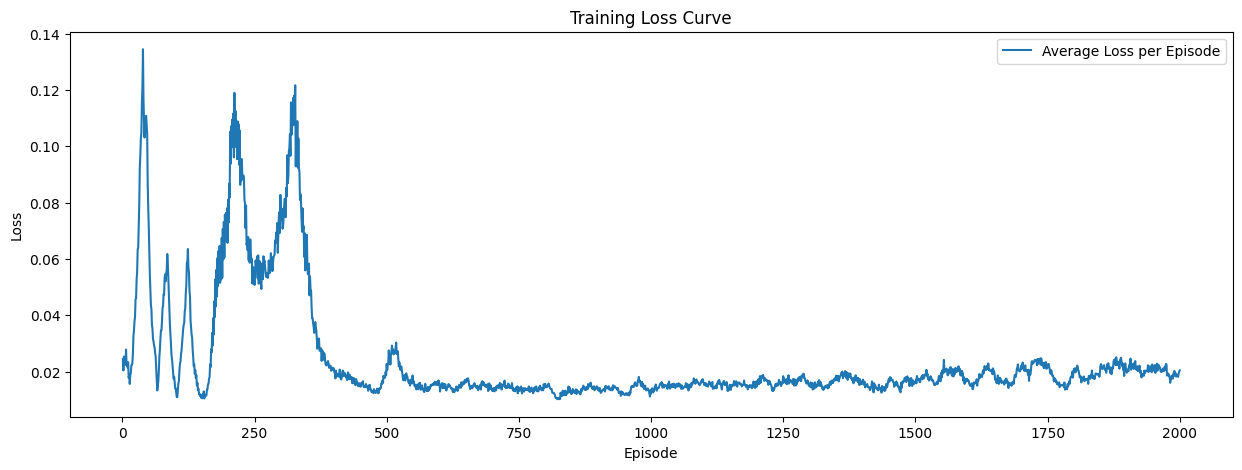

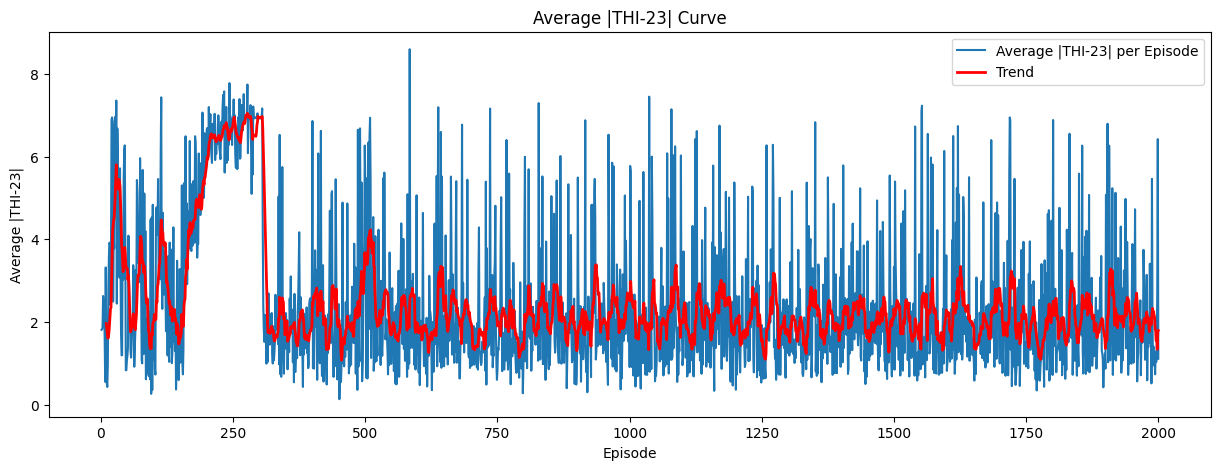

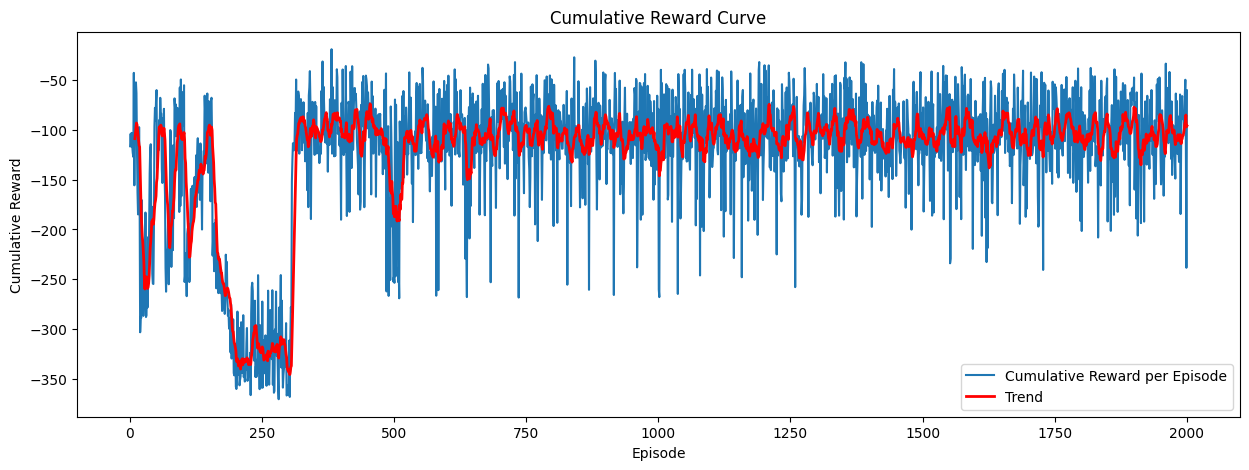

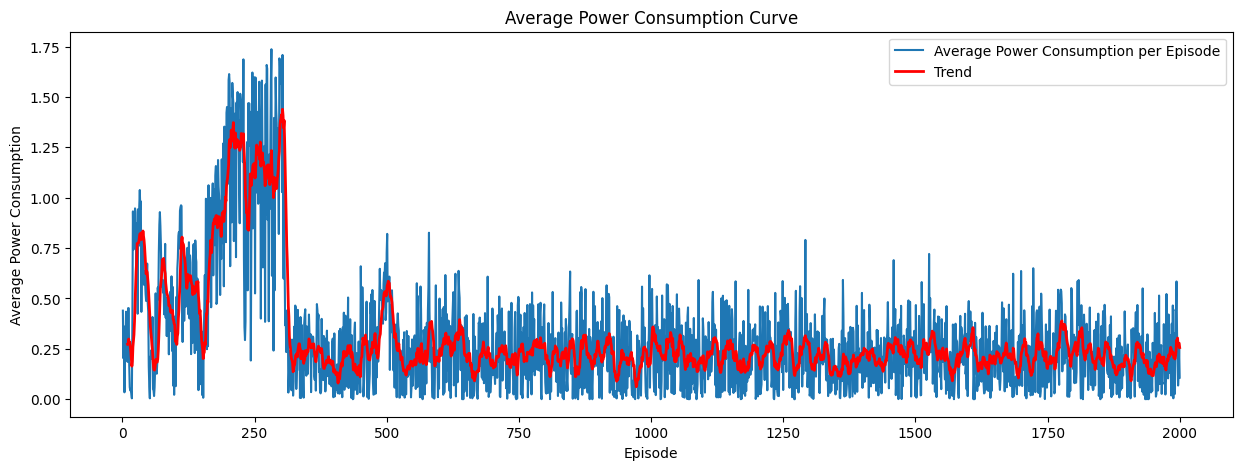

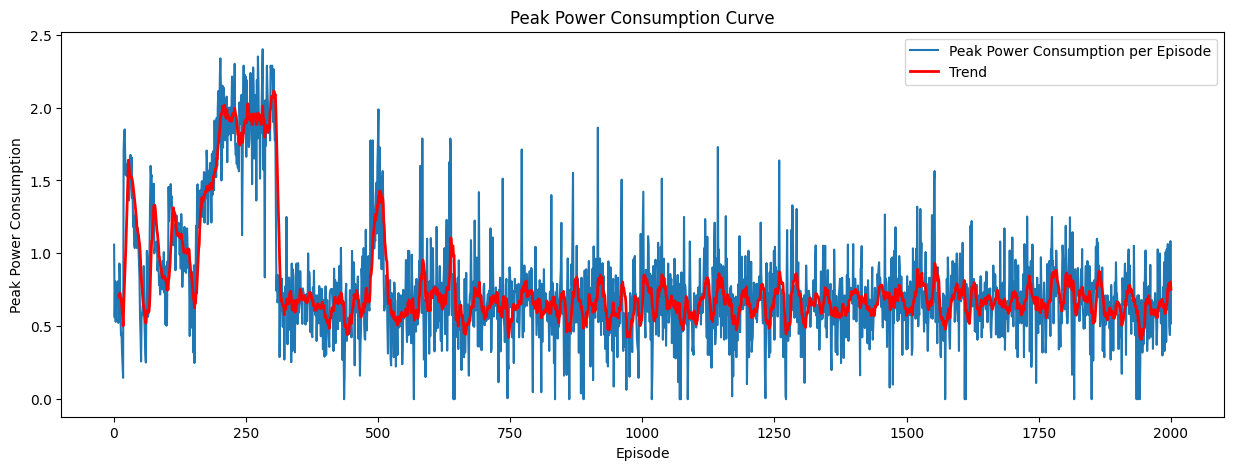

In [ ]:
import matplotlib.pyplot as plt

def moving_average(data, window_size=10):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

window_size = 10

plt.figure(figsize=(15, 5))
plt.plot(range(1, episodes+1), losses_per_episode, label='Average Loss per Episode')
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(range(1, episodes+1), avg_THI_deviation_per_episode, label='Average |THI-23| per Episode')
trend_thi = moving_average(avg_THI_deviation_per_episode, window_size)
plt.plot(range(window_size, episodes+1), trend_thi, color='red', linewidth=2, label='Trend')

plt.xlabel('Episode')
plt.ylabel('Average |THI-23|')
plt.title('Average |THI-23| Curve')
plt.legend()
plt.show()

# Plot Cumulative Reward Curve
plt.figure(figsize=(15, 5))
plt.plot(range(1, episodes+1), cumulative_rewards, label='Cumulative Reward per Episode')
trend_rewards = moving_average(cumulative_rewards, window_size)
plt.plot(range(window_size, episodes+1), trend_rewards, color='red', linewidth=2, label='Trend')

plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Reward Curve')
plt.legend()
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(range(1, episodes+1), avg_power_consumption_per_episode, label='Average Power Consumption per Episode')
trend_avg_power = moving_average(avg_power_consumption_per_episode, window_size)
plt.plot(range(window_size, episodes+1), trend_avg_power, color='red', linewidth=2, label='Trend')

plt.xlabel('Episode')
plt.ylabel('Average Power Consumption')
plt.title('Average Power Consumption Curve')
plt.legend()
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(range(1, episodes+1), peak_power_consumption_per_episode, label='Peak Power Consumption per Episode')
trend_peak_power = moving_average(peak_power_consumption_per_episode, window_size)
plt.plot(range(window_size, episodes+1), trend_peak_power, color='red', linewidth=2, label='Trend')

plt.xlabel('Episode')
plt.ylabel('Peak Power Consumption')
plt.title('Peak Power Consumption Curve')
plt.legend()
plt.show()

### 儲存模型

In [ ]:
import torch
# 儲存模型權重
torch.save(agent.model.state_dict(), '/content/drive/MyDrive/models/dqn_model_v6.5.pth')
print("Saved trained model to Google Drive")

Saved trained model to Google Drive


In [ ]:
# 儲存模型權重（推薦方式）
torch.save(agent.model.state_dict(), 'dqn_model.pth')
print("Saved trained model to dqn_model.pth")

In [ ]:
# 若想載入模型：
import torch

from DQN import DQNAgent
from DQN import DQN
import air_conditioning_env as ac_env
csv_path = "test data_2_11.csv"
env = ac_env.AirConditioningEnv(csv_path)

# Get the dimensions of the environment state and action
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
# DQN Agent
agent = DQNAgent(state_size, action_size)
agent.epsilon = 0  # 確保不探索

# 1. 建立模型架構（與訓練時的架構相同）
model = DQN(state_size, action_size).to(agent.device)
# 2. 載入權重
agent.model.load_state_dict(torch.load('dqn_model_v6.5.pth', map_location=agent.device))
agent.model.eval()  # 設定為 evaluation 模式


DQN(
  (fc1): Linear(in_features=5, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (out): Linear(in_features=64, out_features=3, bias=True)
)

### DQN agent 與 Heuristic 檢測


In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy import stats

# 載入自訂環境與 DQN Agent 模組
import air_conditioning_env as ac_env
from DQN import DQNAgent

test_data_path = "test data_2_11.csv"
hours = 336
test_seed = 999
np.random.seed(test_seed)
torch.manual_seed(test_seed)
agent.epsilon = 0  # 確保不探索

# 建立兩個環境實例，分別用於 DQN agent 與 Heuristic 策略
env_dqn = ac_env.AirConditioningEnv(test_data_path, episode_length=hours)
env_heuristic = ac_env.AirConditioningEnv(test_data_path, episode_length=hours)

state_size = env_dqn.observation_space.shape[0]
action_size = env_dqn.action_space.n

# 載入或訓練好的 DQN agent（這裡假設 agent 已訓練完成）
# agent = DQNAgent(state_size, action_size)
# 若有保存模型權重，可在此載入

def heuristic_policy(state):
    """
    基於政府公家機關的策略：
    - 當室外溫度 > 28℃，期望室內設定為 27℃：
         若目前室內溫度 > 27，採取 action 0 (降低)；
         若 < 27，採取 action 2 (提高)；
         等於 27 則維持 (action 1)。
    - 當室外溫度 < 27℃，則關閉冷氣（目標設定溫度達到 30℃）：
         若目前室內溫度 < 30，採取 action 2 (提高)；
         否則維持 (action 1)。
    - 其他情況則維持 (action 1)。
    """
    T_in = state[0]    # 室內冷氣設定溫度
    T_out = state[1]   # 室外溫度
    T_ac = 27       # 26~28℃
    if T_out > 28:
        if T_in > T_ac:
            return 0  # 降低空調設定溫度
        elif T_in < T_ac:
            return 2  # 提高空調設定溫度
        else:
            return 1  # 維持
    elif T_out < T_ac:
        if T_in < 30:
            return 2  # 提高至關閉冷氣（室內溫度達到 30℃）
        else:
            return 1  # 維持
    else:
        return 1  # 其他情況維持

def run_episode(env, policy_func, max_steps=hours):
    """
    根據給定的 policy (可為 heuristic_policy 或 agent.act)
    執行單一回合並記錄每個 step 的資訊：
    - 累計耗電量（從 info["energy"] 取得）
    - THI（從 info["THI"] 取得）
    - 室內溫度（state[4]）
    - 室外溫度（state[1]）
    """
    # 使用相同 seed 重置環境，確保起始點一致
    state = env.reset(seed=test_seed)
    state = np.reshape(state, [1, env.observation_space.shape[0]])
    steps = []
    energies = []      # 累計耗電量
    THI_values = []    # 舒適度 THI
    dates = []
    T_in_values = []   # 室內溫度
    T_out_values = []  # 室外溫度

    for step in range(max_steps):
        # 如果 policy_func 是 agent.act，傳入 2D state；否則傳入 1D state
        if policy_func == agent.act:
            action = policy_func(state)
        else:
            action = policy_func(state[0])
        next_state, reward, done, info = env.step(action)
        next_state = np.reshape(next_state, [1, env.observation_space.shape[0]])
        state = next_state

        steps.append(step)
        energies.append(info.get("energy", 0))
        THI_values.append(info.get("THI", 0))
        dates.append(info.get("date", 0))
        T_in_values.append(state[0, 4])
        T_out_values.append(state[0, 1])
        if done:
            break
    return steps, energies, THI_values, T_in_values, T_out_values, dates

# 分別用 DQN agent 與 Heuristic 策略執行回合，兩個環境皆以 seed 重置，確保天氣資料相同
dqn_steps, dqn_energies, dqn_THI, dqn_Tin, dqn_Tout, dqn_dates = run_episode(env_dqn, agent.act)
heuristic_steps, heuristic_energies, heuristic_THI, heuristic_Tin, heuristic_Tout, heuristic_dates = run_episode(env_heuristic, heuristic_policy)

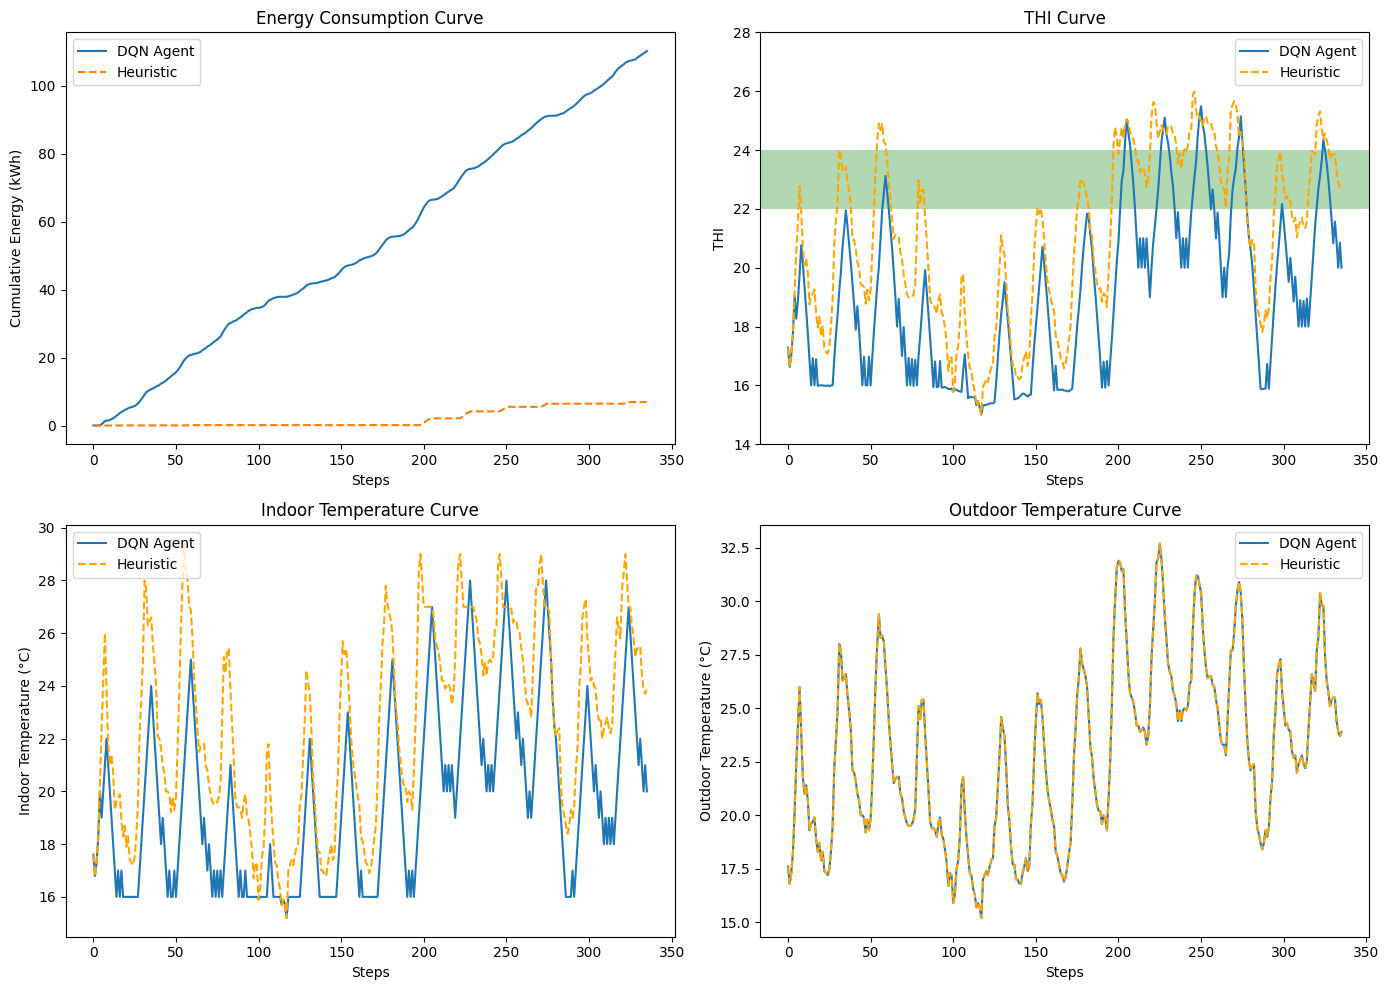

In [ ]:
# 繪圖比較 (2x2 子圖)
plt.figure(figsize=(14, 10))

# 1. 累計耗電量曲線
plt.subplot(2, 2, 1)
plt.plot(dqn_steps, dqn_energies, label="DQN Agent")
plt.plot(heuristic_steps, heuristic_energies, label="Heuristic", linestyle="--")
plt.xlabel("Steps")
plt.ylabel("Cumulative Energy (kWh)")
plt.title("Energy Consumption Curve")
plt.legend()

# 2. THI 舒適度曲線
plt.subplot(2, 2, 2)

ax = plt.gca()
ax.set_ylim(14, 28)

ax.axhspan(22, 24, facecolor='green', alpha=0.3)
# ax.axhspan(19, 22, facecolor='yellow', alpha=0.3)
# ax.axhspan(24, 27, facecolor='yellow', alpha=0.3)
# ax.axhspan(15, 19, facecolor='orange', alpha=0.3)
# ax.axhspan(10, 15, facecolor='red', alpha=0.3)
# ax.axhspan(27, 30, facecolor='red', alpha=0.3)

plt.plot(dqn_steps, dqn_THI, label="DQN Agent")
plt.plot(heuristic_steps, heuristic_THI, label="Heuristic", linestyle="--", color="orange")
plt.xlabel("Steps")
plt.ylabel("THI")
plt.title("THI Curve")
plt.legend()

# 3. 冷氣設定溫度 (T_ac) 曲線
plt.subplot(2, 2, 3)
plt.plot(dqn_steps, dqn_Tin, label="DQN Agent")
plt.plot(heuristic_steps, heuristic_Tin, label="Heuristic", linestyle="--", color="orange")
plt.xlabel("Steps")
plt.ylabel("Indoor Temperature (°C)")
plt.title("Indoor Temperature Curve")
plt.legend()

# 4. 室外溫度 (T_out) 曲線
plt.subplot(2, 2, 4)
plt.plot(dqn_steps, dqn_Tout, label="DQN Agent")
plt.plot(heuristic_steps, heuristic_Tout, label="Heuristic", linestyle="--", color="orange")
plt.xlabel("Steps")
plt.ylabel("Outdoor Temperature (°C)")
plt.title("Outdoor Temperature Curve")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
heuristic_count_22_24 = sum(1 for val in heuristic_THI if 22 <= val <= 24)
heuristic_count_19_27 = sum(1 for val in heuristic_THI if 19 <= val <= 27)

heuristic_prop_22_24 = heuristic_count_22_24 / len(heuristic_THI)
heuristic_prop_19_27 = heuristic_count_19_27 / len(heuristic_THI)

dqn_count_22_24 = sum(1 for val in dqn_THI if 22 <= val <= 24)
dqn_count_19_27 = sum(1 for val in dqn_THI if 19 <= val <= 27)

dqn_prop_22_24 = dqn_count_22_24 / len(dqn_THI)
dqn_prop_19_27 = dqn_count_19_27 / len(dqn_THI)

print(f"date: {dqn_dates[0]} ~ {dqn_dates[-1]}")
print(f"{'heuristic ':.>10}總耗電量：{heuristic_energies[-1]:>5.3f} kWh")
print(f"{'dqn ':>10}總耗電量：{dqn_energies[-1]:>5.3f} kWh")
print("--------------------------")
print(f"{'heuristic ':.>10}最佳舒適占比(22~24)：{heuristic_prop_22_24:.2f}")
print(f"{'dqn ':>10}最佳舒適占比(22~24)：{dqn_prop_22_24:.2f}")
print("--------------------------")
print(f"{'heuristic ':.>10}舒適占比(19~27)：{heuristic_prop_19_27:.2f}")
print(f"{'dqn ':>10}舒適占比(19~27)：{dqn_prop_19_27:.2f}")

date: 2024-03-15 05:00:00 ~ 2024-03-29 04:00:00
heuristic 總耗電量：6.894 kWh
      dqn 總耗電量：110.206 kWh
--------------------------
heuristic 最佳舒適占比(22~24)：0.23
      dqn 最佳舒適占比(22~24)：0.11
--------------------------
heuristic 舒適占比(19~27)：0.71
      dqn 舒適占比(19~27)：0.48


#### 多次試驗與統計檢定

Trial  1:
  DQN Energy = 118.379 kWh, Heuristic Energy =  6.768 kWh
  DQN THI 占比 (22~24): 0.173, (19~27): 0.557
  Heuristic THI 占比 (22~24): 0.283, (19~27): 0.872

Trial  2:
  DQN Energy = 77.614 kWh, Heuristic Energy =  0.000 kWh
  DQN THI 占比 (22~24): 0.000, (19~27): 0.155
  Heuristic THI 占比 (22~24): 0.089, (19~27): 0.372

Trial  3:
  DQN Energy = 115.893 kWh, Heuristic Energy = 51.823 kWh
  DQN THI 占比 (22~24): 0.399, (19~27): 0.884
  Heuristic THI 占比 (22~24): 0.027, (19~27): 0.967

Trial  4:
  DQN Energy = 71.685 kWh, Heuristic Energy =  1.472 kWh
  DQN THI 占比 (22~24): 0.033, (19~27): 0.188
  Heuristic THI 占比 (22~24): 0.098, (19~27): 0.405

Trial  5:
  DQN Energy = 111.022 kWh, Heuristic Energy = 74.720 kWh
  DQN THI 占比 (22~24): 0.342, (19~27): 0.836
  Heuristic THI 占比 (22~24): 0.018, (19~27): 0.988

Trial  6:
  DQN Energy = 119.601 kWh, Heuristic Energy = 32.596 kWh
  DQN THI 占比 (22~24): 0.446, (19~27): 0.985
  Heuristic THI 占比 (22~24): 0.060, (19~27): 0.976

Trial  7:
  DQN Energy =

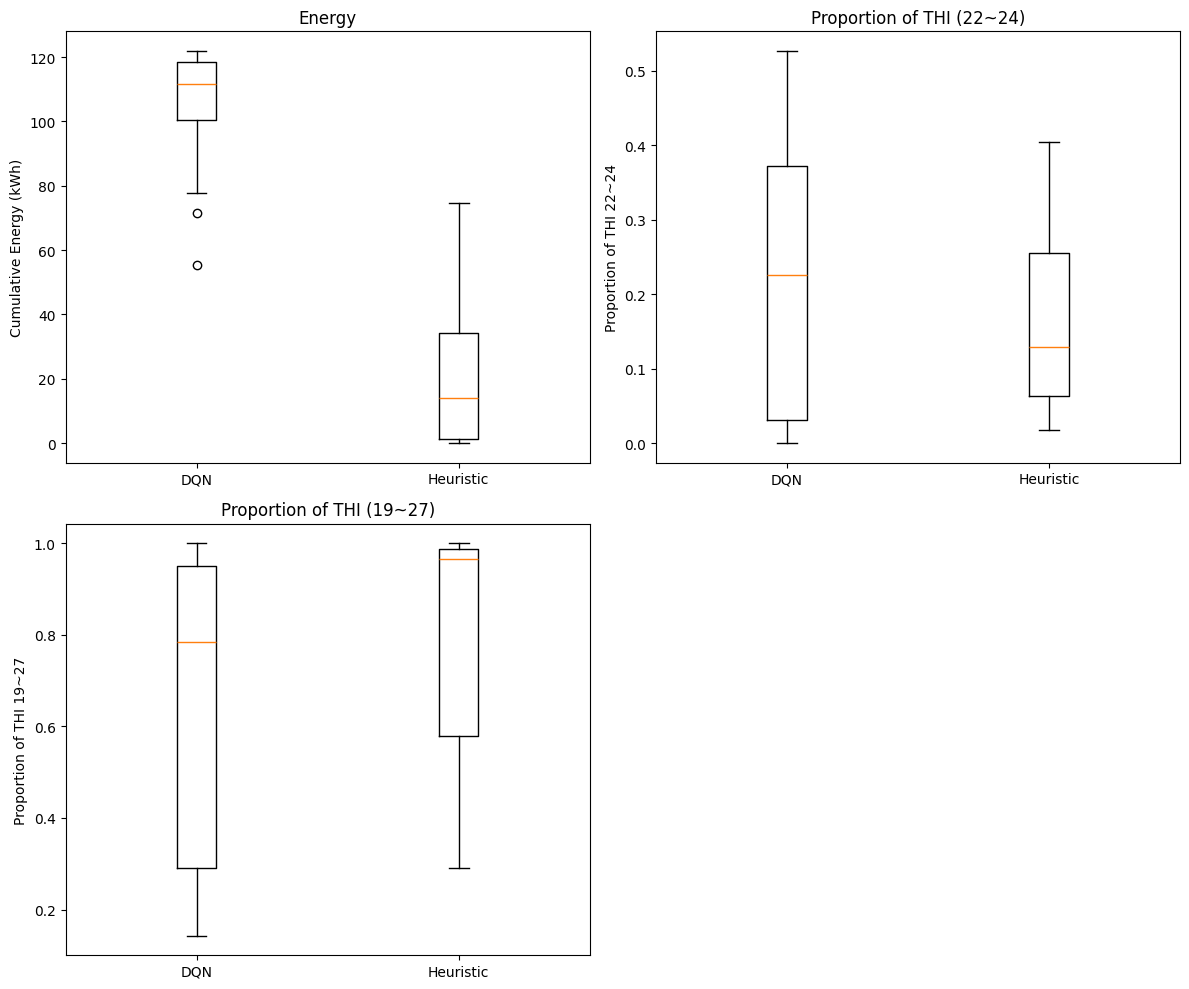

In [ ]:
import os
import random
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy import stats

# 固定所有可能的隨機性來源
def set_all_seeds(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

# 在程式開始時固定一個全局 seed
GLOBAL_SEED = 42
set_all_seeds(GLOBAL_SEED)

# 載入自訂環境與 DQN Agent 模組
import air_conditioning_env as ac_env
from DQN import DQNAgent

# ---------------------------
# 設定參數
# ---------------------------
test_model = 'dqn_model_v6.5.pth'
test_data_path = "test data_2_11.csv"  # 測試資料 CSV
episode_length = 336  # 一回合 336 小時（14 天）
num_trials = 20       # 試驗次數
seed_base = 200       # 起始 seed 值，每個 trial 傳入不同的 seed，但每次跑同一個 trial 都應固定

# ---------------------------
# 建立環境及 DQN Agent
# ---------------------------
# 利用 dummy 環境取得狀態與動作空間維度
env_dummy = ac_env.AirConditioningEnv(test_data_path, episode_length=episode_length)
state_size = env_dummy.observation_space.shape[0]
action_size = env_dummy.action_space.n

# # 假設 DQNAgent 已訓練完成，這裡僅用於評估，不進行探索
# agent = DQNAgent(state_size, action_size)
# agent.epsilon = 0  # 關閉隨機探索

# 1. 建立模型架構（與訓練時的架構相同）
model = DQN(state_size, action_size).to(agent.device)
# 2. 載入權重
agent.model.load_state_dict(torch.load(test_model, map_location=agent.device))
agent.model.eval()  # 設定為 evaluation 模式

# ---------------------------
# 定義 Heuristic 策略
# ---------------------------
def heuristic_policy(state):
    """
    基於政府公家機關的策略：
      - 當室外溫度 > 28℃ 時，期望室內設定為 27℃：
            如果目前室內溫度 > 27，採取 action 0（降低設定溫度）；
            如果低於 27，採取 action 2（提高設定溫度）；
            等於 27 則採取 action 1（維持）。
      - 當室外溫度 < 27℃ 時，則關閉冷氣（目標室內溫度為 30℃）：
            如果目前室內溫度 < 30，採取 action 2（提高設定溫度）；
            否則採取 action 1。
      - 其他情況則採取 action 1 (維持)。
    """
    T_in = state[0]    # 室內冷氣設定溫度
    T_out = state[1]   # 室外溫度
    target = 27
    if T_out > 28:
        if T_in > target:
            return 0
        elif T_in < target:
            return 2
        else:
            return 1
    elif T_out < target:
        if T_in < 30:
            return 2
        else:
            return 1
    else:
        return 1

# ---------------------------
# 定義單回合評估函數
# ---------------------------
def run_episode(env, policy_func, agent=None, max_steps=episode_length, seed=None):
    """
    執行單一回合，並回傳：
      - 累計耗電量（從 info["energy"] 取得）
      - 該回合所有 time step 的 THI 值（list 回傳）
    若使用 DQN 策略，傳入 2D 狀態；若使用 heuristic 策略，則傳入 1D 狀態。
    在 reset 時傳入 seed，環境內部也會用 np.random.seed(seed) 固定起始狀態。
    """
    # 固定本次試驗的 seed（全局也可在此處再次設定）
    set_all_seeds(seed)
    state = env.reset(seed=seed)
    state = np.reshape(state, [1, env.observation_space.shape[0]])
    cumulative_energy = 0
    thi_list = []
    for step in range(max_steps):
        if agent is not None and policy_func == agent.act:
            action = agent.act(state)
        else:
            action = policy_func(state[0])
        next_state, reward, done, info = env.step(action)
        cumulative_energy = info.get("energy", cumulative_energy)
        thi = info.get("THI", 0)
        thi_list.append(thi)
        state = np.reshape(next_state, [1, env.observation_space.shape[0]])
        if done:
            break
    return cumulative_energy, thi_list

# ---------------------------
# 多次試驗與數據收集
# ---------------------------
# 儲存累計耗電量與 THI 占比
dqn_energies = []
heuristic_energies = []

# 儲存 THI 在 22~24 及 19~27 區間的比例
dqn_prop_22_24_list = []
dqn_prop_19_27_list = []
heuristic_prop_22_24_list = []
heuristic_prop_19_27_list = []

for trial in range(num_trials):
    trial_seed = seed_base + trial  # 每次 trial 的 seed 會固定，只要程式重新跑，結果應一致
    # 建立兩個環境實例，並以相同 seed 重置，確保 DQN 與 Heuristic 在相同條件下評估
    env_dqn = ac_env.AirConditioningEnv(test_data_path, episode_length=episode_length)
    env_heuristic = ac_env.AirConditioningEnv(test_data_path, episode_length=episode_length)

    energy_dqn, thi_dqn = run_episode(env_dqn, agent.act, agent=agent, max_steps=episode_length, seed=trial_seed)
    energy_heuristic, thi_heuristic = run_episode(env_heuristic, heuristic_policy, max_steps=episode_length, seed=trial_seed)

    dqn_energies.append(energy_dqn)
    heuristic_energies.append(energy_heuristic)

    # 計算 DQN 策略中 THI 占比
    dqn_count_22_24 = sum(1 for val in thi_dqn if 22 <= val <= 24)
    dqn_count_19_27 = sum(1 for val in thi_dqn if 19 <= val <= 27)
    dqn_prop_22_24 = dqn_count_22_24 / len(thi_dqn) if len(thi_dqn) > 0 else 0
    dqn_prop_19_27 = dqn_count_19_27 / len(thi_dqn) if len(thi_dqn) > 0 else 0

    dqn_prop_22_24_list.append(dqn_prop_22_24)
    dqn_prop_19_27_list.append(dqn_prop_19_27)

    # 計算 Heuristic 策略中 THI 占比
    heuristic_count_22_24 = sum(1 for val in thi_heuristic if 22 <= val <= 24)
    heuristic_count_19_27 = sum(1 for val in thi_heuristic if 19 <= val <= 27)
    heuristic_prop_22_24 = heuristic_count_22_24 / len(thi_heuristic) if len(thi_heuristic) > 0 else 0
    heuristic_prop_19_27 = heuristic_count_19_27 / len(thi_heuristic) if len(thi_heuristic) > 0 else 0

    heuristic_prop_22_24_list.append(heuristic_prop_22_24)
    heuristic_prop_19_27_list.append(heuristic_prop_19_27)

    print(f"Trial {trial+1:2d}:")
    print(f"  DQN Energy = {energy_dqn:6.3f} kWh, Heuristic Energy = {energy_heuristic:6.3f} kWh")
    print(f"  DQN THI 占比 (22~24): {dqn_prop_22_24:.3f}, (19~27): {dqn_prop_19_27:.3f}")
    print(f"  Heuristic THI 占比 (22~24): {heuristic_prop_22_24:.3f}, (19~27): {heuristic_prop_19_27:.3f}\n")

# ---------------------------
# 統計分析
# ---------------------------
dqn_energies = np.array(dqn_energies)
heuristic_energies = np.array(heuristic_energies)
dqn_prop_22_24_list = np.array(dqn_prop_22_24_list)
dqn_prop_19_27_list = np.array(dqn_prop_19_27_list)
heuristic_prop_22_24_list = np.array(heuristic_prop_22_24_list)
heuristic_prop_19_27_list = np.array(heuristic_prop_19_27_list)

print("=== 能耗統計 ===")
print(f"{'DQN ':>10}平均耗電量: {np.mean(dqn_energies):.3f} kWh, 標準差: {np.std(dqn_energies):.3f}")
print(f"{'Heuristic ':.>10}平均耗電量: {np.mean(heuristic_energies):.3f} kWh, 標準差: {np.std(heuristic_energies):.3f}")
t_stat_energy, p_value_energy = stats.ttest_rel(dqn_energies, heuristic_energies)
print(f"配對 t 檢定（能耗）: t = {t_stat_energy:.3f}, p = {p_value_energy:.3f}\n")

print("=== THI 占比 (22~24) 統計 ===")
print(f"{'DQN ':>10}平均占比: {np.mean(dqn_prop_22_24_list):.3f}, 標準差: {np.std(dqn_prop_22_24_list):.3f}")
print(f"{'Heuristic ':.>10}平均占比: {np.mean(heuristic_prop_22_24_list):.3f}, 標準差: {np.std(heuristic_prop_22_24_list):.3f}")
t_stat_22_24, p_value_22_24 = stats.ttest_rel(dqn_prop_22_24_list, heuristic_prop_22_24_list)
print(f"配對 t 檢定 (22~24): t = {t_stat_22_24:.3f}, p = {p_value_22_24:.3f}\n")

print("=== THI 占比 (19~27) 統計 ===")
print(f"{'DQN ':>10}平均占比: {np.mean(dqn_prop_19_27_list):.3f}, 標準差: {np.std(dqn_prop_19_27_list):.3f}")
print(f"{'Heuristic ':.>10}平均占比: {np.mean(heuristic_prop_19_27_list):.3f}, 標準差: {np.std(heuristic_prop_19_27_list):.3f}")
t_stat_19_27, p_value_19_27 = stats.ttest_rel(dqn_prop_19_27_list, heuristic_prop_19_27_list)
print(f"配對 t 檢定 (19~27): t = {t_stat_19_27:.3f}, p = {p_value_19_27:.3f}\n")

# ---------------------------
# 可視化結果 (箱形圖)
# ---------------------------
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.boxplot([dqn_energies, heuristic_energies], tick_labels=["DQN", "Heuristic"])
plt.ylabel("Cumulative Energy (kWh)")
plt.title("Energy")

plt.subplot(2, 2, 2)
plt.boxplot([dqn_prop_22_24_list, heuristic_prop_22_24_list], tick_labels=["DQN", "Heuristic"])
plt.ylabel("Proportion of THI 22~24")
plt.title("Proportion of THI (22~24)")

plt.subplot(2, 2, 3)
plt.boxplot([dqn_prop_19_27_list, heuristic_prop_19_27_list], tick_labels=["DQN", "Heuristic"])
plt.ylabel("Proportion of THI 19~27")
plt.title("Proportion of THI (19~27)")

plt.tight_layout()
plt.show()


### 老程式

In [ ]:
# Calculate the indoor dew point temperature Td
    def calculate_Td(self, T, AH):
        """
        Based on the Magnus-Tetens formula
        """
        RH = self.absolute_to_relative_humidity(T, AH)
        if RH == 0:
            raise ValueError("RH error")
            print(f"current index{self.current_index}")
        a = 17.27
        b = 237.7
        alpha = (a * T) / (b + T) + math.log(RH / 100)
        Td = (b * alpha) / (a - alpha)
        return Td